In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.dates import DateFormatter, HourLocator
from scipy.stats import skew, kurtosis

# Disable Warnings
import warnings
warnings.filterwarnings('ignore')
# Allow Multiple Output per Cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
# StatsModels for Ordinary Least Squares Regresssion
import statsmodels.api as sm
# Import the adfuller (ADF) Stationarity Test
from statsmodels.tsa.stattools import adfuller
# Import QuantStats for Trading Strategy Tear-Sheets
import quantstats as qs

### Add first moment analysis, normality check + fourth moment analysis

In [2]:
# All data from binance or binance futures || Base currency is USDT

df_btc = pd.read_csv('candle_bns_btc_usdt_1m_202403011651.csv')
df_eth = pd.read_csv('candle_bns_eth_usdt_1m_202403011652.csv')

df_btc_perp = pd.read_csv('candle_bnf_btc_usdt_perpetual_1m_202403011649.csv') 
df_eth_perp = pd.read_csv('candle_bnf_eth_usdt_perpetual_1m_202403011650.csv')

# Sort dataframes by 'timestamp'
df_btc = df_btc.sort_values(by='timestamp')
df_eth = df_eth.sort_values(by='timestamp')
df_btc_perp = df_btc_perp.sort_values(by='timestamp')
df_eth_perp = df_eth_perp.sort_values(by='timestamp')

### Convert to daily data

In [3]:
def convert_to_daily_data(df_btc):
    # Convert 'timestamp' column to datetime
    df_btc['timestamp'] = pd.to_datetime(df_btc['timestamp'])

    # Group by date and aggregate the data
    daily_df_btc = df_btc.groupby(df_btc['timestamp'].dt.date).agg({
        'open': 'first',
        'close': 'last',
        'low': 'min',
        'high': 'max',
        'volume': 'sum',
        'cont_records': 'sum',
        'quote_volume': 'sum'
    }).reset_index()

    return daily_df_btc

daily_df_btc = convert_to_daily_data(df_btc)
daily_df_eth = convert_to_daily_data(df_eth)
daily_df_btc_perp = convert_to_daily_data(df_btc_perp)
daily_df_eth_perp = convert_to_daily_data(df_eth_perp)

### Crypto Carry Equation
### f_i_t,T - s_i_t = r_t,T - r*_t,T + δ_t,T + ε_i_t

### Where:

### f_i_t,T is the log futures price for a crypto asset from t to T
### s_i_t is the log spot price
### r_t,T and r*_t,T are the USD and crypto risk-free rates, respectively
### δ_t,T is the crypto convenience yield
### ε_i_t is an exchange-specific pricing error

### Carry Calculation

In [4]:
daily_df_btc['carry'] = np.log(daily_df_btc_perp['close']) - np.log(daily_df_btc['close'])
daily_df_eth['carry'] = np.log(daily_df_eth_perp['close']) - np.log(daily_df_eth['close'])
daily_df_btc = daily_df_btc.dropna()
daily_df_eth = daily_df_eth.dropna()

In [6]:


daily_df_btc

,timestamp,open,close,low,high,volume,cont_records,quote_volume,carry
0,2022-12-31,16520.28,16542.40,16487.74,16551.24,4973.43307,152632,8.217183e+07,0.550862
1,2023-01-01,16541.77,16616.75,16499.01,16628.00,96925.41374,3218355,1.604794e+09,0.579152
2,2023-01-02,16617.17,16672.87,16548.70,16799.23,121888.57191,4036118,2.034683e+09,0.583922
3,2023-01-03,16672.78,16675.18,16605.28,16778.40,159541.53733,5097596,2.662766e+09,0.586659
4,2023-01-04,16675.65,16850.36,16652.66,16991.87,220362.18862,6310703,3.709833e+09,0.674375
...,...,...,...,...,...,...,...,...,...
130,2023-05-10,27628.28,27598.75,26777.00,28331.42,71155.11355,1534579,1.971173e+09,0.685582
131,2023-05-11,27598.74,26968.62,26702.05,27630.14,47635.31365,1257000,1.295799e+09,0.749683
132,2023-05-12,26968.61,26795.01,25811.46,27091.12,67207.93494,1351633,1.777052e+09,0.846757
133,2023-05-13,26795.01,26775.28,26692.03,27045.45,22814.90421,605049,6.120629e+08,0.826722


In [5]:
# Concatenate daily data for BTC and ETH spot markets
daily_spot_df = pd.concat([daily_df_btc, daily_df_eth], keys=['btc', 'eth'])
daily_spot_df = daily_spot_df.reset_index(level=1, drop=True)
daily_spot_df = daily_spot_df.reset_index().rename(columns={'level_0': 'asset'})

# Concatenate daily data for BTC and ETH perpetual futures markets
daily_perp_df = pd.concat([daily_df_btc_perp, daily_df_eth_perp], keys=['btc', 'eth'])
daily_perp_df = daily_perp_df.reset_index(level=1, drop=True)
daily_perp_df = daily_perp_df.reset_index().rename(columns={'level_0': 'asset'})

# Merge spot and perpetual futures data
combined_df = pd.merge(daily_spot_df, daily_perp_df, on=['timestamp', 'index'], suffixes=['_spot', '_perp'])
combined_df["exchange"] = "Binance"

### Regression analysis to dissect the drivers of carry -->  contribution of interest rate differentials, exchange-specific factors, and convenience yields to the variation in carry.

In [8]:
daily_df_btc

,timestamp,open,close,low,high,volume,cont_records,quote_volume,carry
0,2022-12-31,16520.28,16542.40,16487.74,16551.24,4973.43307,152632,8.217183e+07,0.550862
1,2023-01-01,16541.77,16616.75,16499.01,16628.00,96925.41374,3218355,1.604794e+09,0.579152
2,2023-01-02,16617.17,16672.87,16548.70,16799.23,121888.57191,4036118,2.034683e+09,0.583922
3,2023-01-03,16672.78,16675.18,16605.28,16778.40,159541.53733,5097596,2.662766e+09,0.586659
4,2023-01-04,16675.65,16850.36,16652.66,16991.87,220362.18862,6310703,3.709833e+09,0.674375
...,...,...,...,...,...,...,...,...,...
130,2023-05-10,27628.28,27598.75,26777.00,28331.42,71155.11355,1534579,1.971173e+09,0.685582
131,2023-05-11,27598.74,26968.62,26702.05,27630.14,47635.31365,1257000,1.295799e+09,0.749683
132,2023-05-12,26968.61,26795.01,25811.46,27091.12,67207.93494,1351633,1.777052e+09,0.846757
133,2023-05-13,26795.01,26775.28,26692.03,27045.45,22814.90421,605049,6.120629e+08,0.826722


In [9]:
# Regression with exchange fixed effects
# exchange_fe_model = sm.OLS.from_formula('carry ~ C(exchange)', data=combined_df).fit()

# Regression with time fixed effects
time_fe_model = sm.OLS.from_formula('carry ~ C(timestamp)', data=daily_df_btc).fit()

# Regression with interest rate differentials
# ir_diff_model = sm.OLS.from_formula('carry ~ ir_diff_usd - ir_diff_crypto', data=combined_df).fit()

                            OLS Regression Results                            
Dep. Variable:                  carry   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 13 Mar 2024   Prob (F-statistic):                nan
Time:                        08:05:53   Log-Likelihood:                 4375.1
No. Observations:                 135   AIC:                            -8480.
Df Residuals:                       0   BIC:                            -8088.
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

<Figure size 1200x600 with 0 Axes>

Text(0.5, 1.0, 'Residuals Plot')

Text(0.5, 0, 'Timestamp')

Text(0, 0.5, 'Residuals')

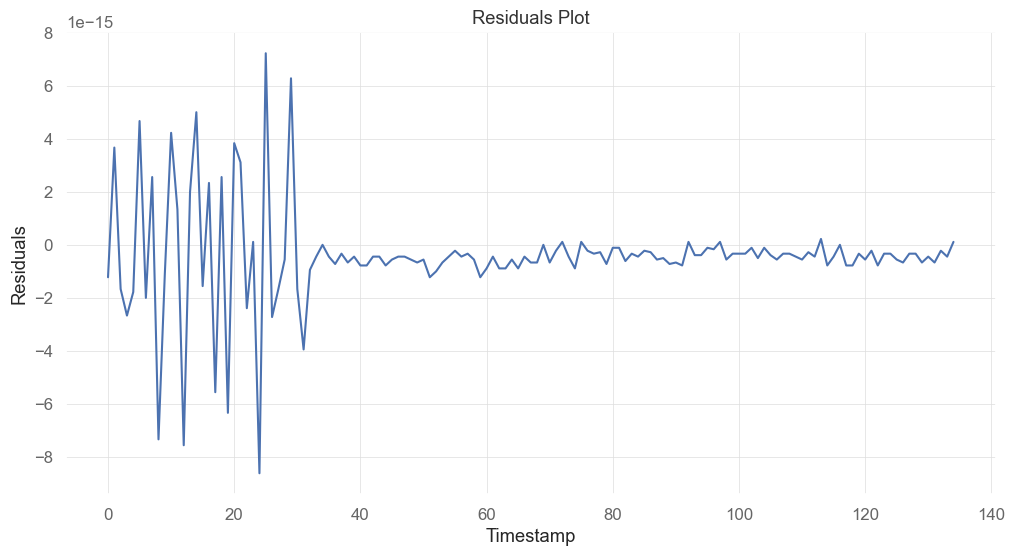

In [14]:
# time_fe_model analysis

# Fit the model
time_fe_model = sm.OLS.from_formula('carry ~ C(timestamp)', data=daily_df_btc).fit()

# Print the summary of the model
print(time_fe_model.summary())

# Access model parameters
params = time_fe_model.params
print('Model Parameters:', params)

# Access model confidence intervals
conf_int = time_fe_model.conf_int(alpha=0.05)
print('Confidence Intervals:\n', conf_int)

# Access model R-squared
r_squared = time_fe_model.rsquared
print('R-squared:', r_squared)

# Access model F-statistic and p-value
f_statistic = time_fe_model.fvalue
f_p_value = time_fe_model.f_pvalue
print('F-statistic:', f_statistic)
print('F-statistic p-value:', f_p_value)

# Analyze residuals
residuals = time_fe_model.resid
print('Residuals:\n', residuals)

# Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(daily_df_btc.index, residuals)
plt.title('Residuals Plot')
plt.xlabel('Timestamp')
plt.ylabel('Residuals')
plt.show()


### Fama regressions --> decompose carry into spot price changes and futures premium changes.


In [ ]:
# Fama regression for spot price changes
fama_spot_model = sm.OLS.from_formula('spot_change ~ carry', data=combined_df).fit()

# Fama regression for futures premium changes
fama_futures_model = sm.OLS.from_formula('futures_change ~ carry', data=combined_df).fit()

### Investor positioning analysis

In [ ]:
# Regression of carry on net futures positions of different trader groups
cot_model = sm.OLS.from_formula('carry ~ dealer_pos + leveraged_pos + nonreportable_pos + other_pos', data=cot_df).fit()

### Trend-following and attention analysis

In [ ]:
# Regression of carry on social media metrics and past returns
trend_model = sm.OLS.from_formula('carry ~ reddit_subs + past_return_1w + past_return_1m', data=combined_df).fit()

### Risk and return analysis of the cash and carry strategy

In [ ]:
# Calculate cash and carry strategy returns
combined_df['carry_returns'] = np.where(combined_df['carry'] > 0,
                                        combined_df['spot_change'] - combined_df['futures_change'],
                                        combined_df['futures_change'] - combined_df['spot_change'])

# Calculate Sharpe Ratio
carry_sharpe_ratio = combined_df['carry_returns'].mean() / combined_df['carry_returns'].std() * np.sqrt(252)

# Regression of contract liquidations on lagged carry
liquidations_model = sm.OLS.from_formula('liquidations ~ carry.shift(1)', data=combined_df).fit()

### Crypto carry and crash risk analysis
### Investigate the link between crypto carry and crash risk using option market data.

In [ ]:
# Regression of implied skewness on carry
skew_model = sm.OLS.from_formula('implied_skew ~ carry', data=combined_df).fit()

# Regression of realized skewness on lagged carry
realized_skew_model = sm.OLS.from_formula('realized_skew ~ carry.shift(1)', data=combined_df).fit()

### Visualization

In [ ]:
# Time-series plot of carry
plt.figure(figsize=(12, 6))
plt.plot(daily_df_btc['timestamp'], daily_df_btc['carry'])
plt.title('Bitcoin Carry over Time')
plt.xlabel('Date')
plt.ylabel('Carry')
plt.show()

# Scatter plot of carry against Reddit subscribers
plt.figure(figsize=(8, 6))
plt.scatter(daily_df_btc['reddit_subs'], daily_df_btc['carry'])
plt.title('Bitcoin Carry vs. Reddit Subscribers')
plt.xlabel('Reddit Subscribers')
plt.ylabel('Carry')
plt.show()

# Plot of regression coefficients
coef_plot = pd.Series(trend_model.params)
coef_plot.plot(kind='bar', yerr=trend_model.bse, capsize=4)
plt.title('Regression Coefficients: Carry on Trend and Attention Variables')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.show()